In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import cross_val_score

In [2]:
# Load the dataset

filepath = "yelp.csv"
df = pd.read_csv(filepath)
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [3]:
# Check for size of data
df.shape

(10000, 10)

# Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [5]:
df.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


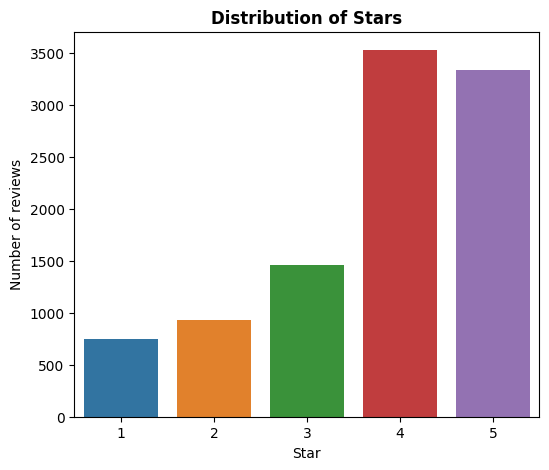

In [6]:
# Checking the distribution

plt.figure(figsize=(6,5))

sns.countplot(x='stars', data=df)
plt.title('Distribution of Stars', fontweight="bold")

plt.xlabel('Star')
plt.ylabel('Number of reviews')
plt.show()


#### The dataset appears to be unbalanced as the number of reviews with a rating of 4 and 5 stars is much higher than the number of reviews with a rating of 1, 2, or 3 stars.

This can lead to issues when building a sentiment analysis model as it may become biased towards predicting positive sentiments due to the higher number of positive reviews. To mitigate this, techniques such as resampling the data or adjusting the class weights can be used.

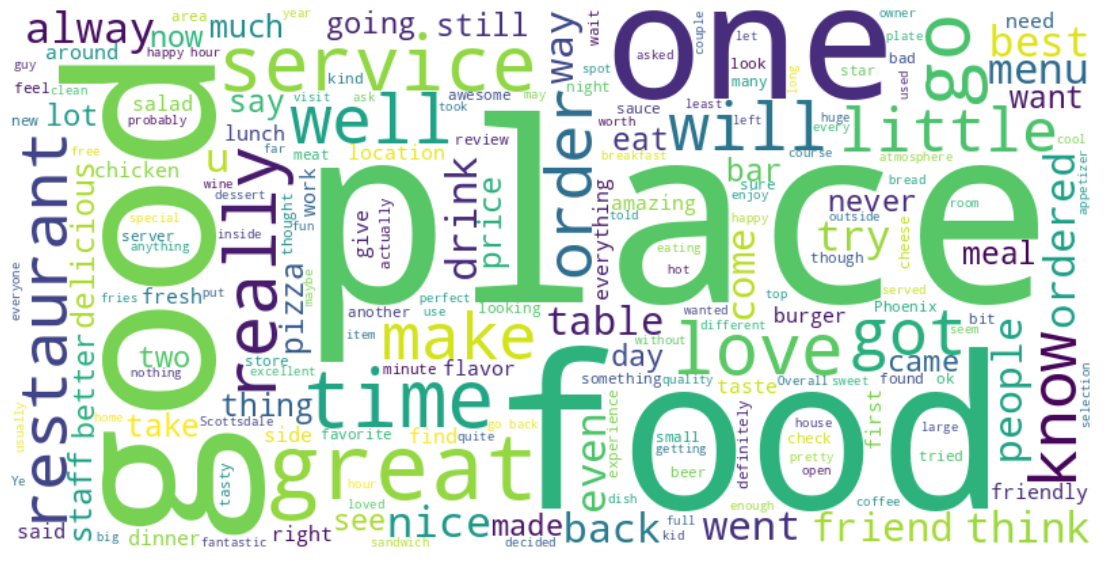

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10))

text = " ".join(review for review in df.text)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

From the word cloud, we can see that the words "good" and "great" are two adjectives that were used a lot for the reviews. This doesn't necessarily mean anything since the actual sentences could have a negation before these adjectives, thus changing the meaning of the review.

<ipython-input-8-34f5737a3ddc>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


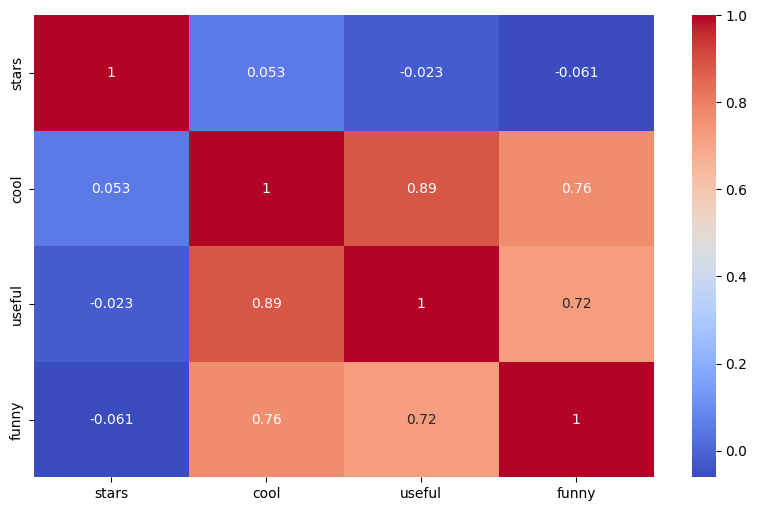

In [8]:
plt.figure(figsize=(10,6))

corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

Looking at the map, funny and cool are strongly correlated with useful. 


# Count the Punctutation Marks

In [9]:
import string

# define a function to count punctuation marks in a string
def count_punctuation_marks(text):
    punctuation_count = sum([1 for char in text if char in string.punctuation])
    return punctuation_count

# apply the function to the text column of the DataFrame
df['punctuation_count'] = df['text'].apply(count_punctuation_marks)

# print the total punctuation count
print("Total punctuation count:", df['punctuation_count'].sum())

Total punctuation count: 240117


# Remove Punctuation Marks

In [10]:
# define a function to remove punctuation marks from a string
def remove_punctuation_marks(text):
    text_no_punct = "".join([char for char in text if char not in string.punctuation])
    return text_no_punct

# apply the function to the text column of the DataFrame
df['text'] = df['text'].apply(remove_punctuation_marks)

# print the total punctuation count
print("Total punctuation count:", df['text'].apply(count_punctuation_marks).sum())

Total punctuation count: 0


In [11]:
#change all strings to be lower
df['text']=df['text'].str.lower()

# Data Cleaning

### 1. Missing Values

In [12]:
# Check for missing values 
df.isna().sum()

business_id          0
date                 0
review_id            0
stars                0
text                 0
type                 0
user_id              0
cool                 0
useful               0
funny                0
punctuation_count    0
dtype: int64

There is no missing data.

### 2. Duplicates

In [13]:
# check for duplicate rows
duplicate_rows = df[df.duplicated()]

# check if there are any duplicates
if duplicate_rows.empty:
    print("There are no duplicate rows in the dataset.")
else:
    # print the duplicate rows
    print("Duplicate rows in the dataset are:", duplicate_rows)

There are no duplicate rows in the dataset.


### 3. Change Data Type

In [14]:
# Convert the date column to a datetime data type
df['date'] = pd.to_datetime(df['date'])

# Check the data type of the date column
print(df['date'].dtype)

datetime64[ns]


### 4. Removing Irrelevant Column 

In [15]:
df['type'].value_counts()

review    10000
Name: type, dtype: int64

Since all rows in the column 'type' are 'review', hence unecessary column.

In [16]:
df = df.drop('type', axis=1)
df = df.drop('business_id', axis=1)
df = df.drop('review_id', axis=1)
df = df.drop('user_id', axis=1)

df = df.drop('punctuation_count', axis=1)

df

,date,stars,text,cool,useful,funny
0,2011-01-26,5,my wife took me here on my birthday for breakf...,2,5,0
1,2011-07-27,5,i have no idea why some people give bad review...,0,0,0
2,2012-06-14,4,love the gyro plate rice is so good and i also...,0,1,0
3,2010-05-27,5,rosie dakota and i love chaparral dog park its...,1,2,0
4,2012-01-05,5,general manager scott petello is a good egg no...,0,0,0
...,...,...,...,...,...,...
9995,2012-07-28,3,first visithad lunch here today used my group...,1,2,0
9996,2012-01-18,4,should be called house of deliciousness\n\ni c...,0,0,0
9997,2010-11-16,4,i recently visited olive and ivy for business ...,0,0,0
9998,2012-12-02,2,my nephew just moved to scottsdale recently so...,0,0,0


### 5. Create new features

In [17]:
df['review length'] = df['text'].apply(len)
df.head()

,date,stars,text,cool,useful,funny,review length
0,2011-01-26,5,my wife took me here on my birthday for breakf...,2,5,0,868
1,2011-07-27,5,i have no idea why some people give bad review...,0,0,0,1309
2,2012-06-14,4,love the gyro plate rice is so good and i also...,0,1,0,73
3,2010-05-27,5,rosie dakota and i love chaparral dog park its...,1,2,0,401
4,2012-01-05,5,general manager scott petello is a good egg no...,0,0,0,431


* Knowing the length of each review can provide insights into the writing style of the reviewers and the amount of detail they provide.

* It can also help in identifying any patterns in the data, such as whether longer reviews tend to be more positive or negative compared to shorter reviews. 


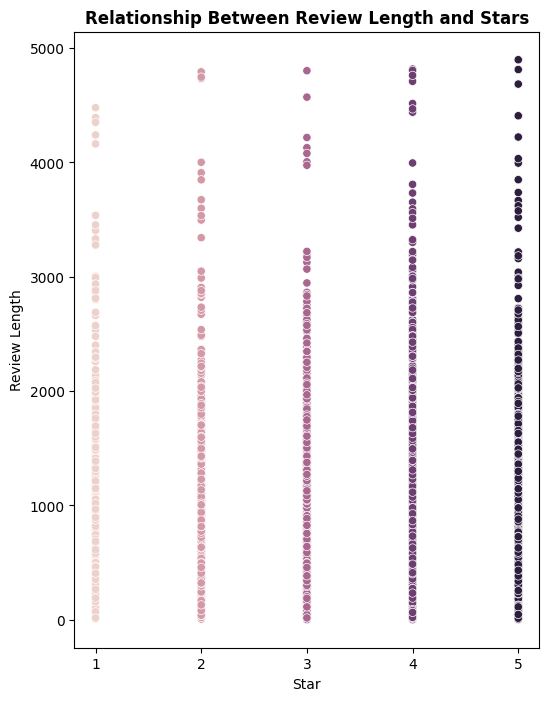

In [18]:
plt.figure(figsize=(6,8))

sns.scatterplot( x='stars', y='review length', hue= 'stars', data=df, legend=False)
plt.title('Relationship Between Review Length and Stars', fontweight="bold")
plt.xticks(np.arange(1, 6, 1))

plt.ylabel('Review Length')
plt.xlabel('Star')
plt.show()

#### Creating a column named ‘sentiment’,  where we assign the sentiment grouping values.

Classifies the sentiment of Yelp reviews into one of five categories: bad, poor, neutral, good, great

In [19]:
df.loc[df['stars'] == 1, 'sentiment'] = 'bad' 
df.loc[df['stars'] == 2, 'sentiment'] = 'poor' 
df.loc[df['stars'] == 3, 'sentiment'] = 'neutral' 
df.loc[df['stars'] == 4, 'sentiment'] = 'good' 
df.loc[df['stars'] == 5, 'sentiment'] = 'great' 

In [20]:
df.head(15)

,date,stars,text,cool,useful,funny,review length,sentiment
0,2011-01-26,5,my wife took me here on my birthday for breakf...,2,5,0,868,great
1,2011-07-27,5,i have no idea why some people give bad review...,0,0,0,1309,great
2,2012-06-14,4,love the gyro plate rice is so good and i also...,0,1,0,73,good
3,2010-05-27,5,rosie dakota and i love chaparral dog park its...,1,2,0,401,great
4,2012-01-05,5,general manager scott petello is a good egg no...,0,0,0,431,great
5,2007-12-13,4,quiessence is simply put beautiful full windo...,4,3,1,2030,good
6,2010-02-12,5,drop what youre doing and drive here after i a...,7,7,4,1515,great
7,2012-07-12,4,luckily i didnt have to travel far to make my ...,0,1,0,265,good
8,2012-08-17,4,definitely come for happy hour prices are amaz...,0,0,0,336,good
9,2010-08-11,5,nobuo shows his unique talents with everything...,0,1,0,182,great


# Storing the cleaned dataset

In [21]:
# assume that the cleaned data is stored in a variable called "cleaned_yelp_data"
df.to_csv('cleaned_yelp_data.csv', index=False)

---------------



# Sentiment Analysis of Yelp reviews involves two broad steps: 


1. Text preprocessing
2. Multiclass classification. 


### Part 1
In the text preprocessing stage, natural language processing (NLP) techniques will be used to prepare the reviews for analysis.

1. Tokenization
2. Lemmat
3. Word Embedding (Word2Vec & Fastext)
4. Vectorized


* The reviews will undergo tokenization, where they will be split into individual words or tokens. 

* Stop words, such as "the" and "and," will be removed to reduce noise in the data. 

* The remaining words will be lemmatized, where they will be transformed into their base form to reduce the number of unique words in the dataset. 

*  Word Embedding techniques can be applied to create a dense representation of words in the form of word vectors.

* Finally, the reviews will be vectorized, where each review will be represented as a numerical vector. 



### Part 2

* In the multiclass classification stage, classification models such as Naïve Bayes, SVM, and Random Forest will be trained on the processed reviews. 

* These models will classify the reviews into five categories. By using these techniques, we can develop accurate and robust sentiment analysis models for Yelp reviews.


# Text preprocessing


The goal of text preprocessing is to clean and transform the raw text data in such a way that it becomes easier to analyze. 


#### STEPS:

* Tokenization: Process of splitting the text into individual words/tokens.

* Stop word removal: Removing common meaningless words, such as "the" & "and".

* Lemmatization: Transforming each word to its base form to reduce the number of unique words in the dataset.

* Word Embedding: Generate dense vector representations of words that capture their semantic meanings.

* Vectorization: Representing each review as a numerical vector so that it can be used as input to machine learning models.



In [22]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

* The wordnet is a lexical database that provides information about words, such as their meanings, synonyms, and antonyms.

* stop_words is a set of English stopwords that is used to remove them from text data.

* lemmatizer is an object of WordNetLemmatizer class, which is used to perform lemmatization on words. Lemmatization is the process of reducing words to their base or root form so that they can be compared more easily. For example, the words "running", "ran", and "runs" can be reduced to their base form "run". By removing variations of words like this, we can reduce the number of unique words in the dataset and make it easier to analyze.


In [23]:
# Download stopwords and wordnet dictionary

nltk.download('wordnet')
nltk.download('stopwords')


# Initialize stop words and lemmatizer

stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# Define a function to preprocess the text

def preprocess_text(text):
    
    # Tokenize the text
    tokens = text.split()
    
    # Remove stop words
    tokens = [token for token in tokens if token.lower() not in stop_words]
    
    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join the tokens back into a single string
    processed_text = ' '.join(tokens)
    return processed_text


The function preprocess_text takes a string of text as input and performs several preprocessing steps on it to clean and normalize the text. 

### Preprocessing text data.

First, a function named 'preprocess_text' is defined to preprocess the text data. 
This function takes the text as an input, tokenizes it by splitting it into individual words or tokens, removes stop words like "the" & "and" which don't carry much meaning, lemmatizes the tokens which involves reducing each word to its base form to reduce the number of unique words in the dataset, and then joins the tokens back into a single string.





In [25]:
# Apply the preprocess_text function to the entire 'text' column
df['processed_text'] = df['text'].apply(preprocess_text)

# Print the processed text
print(df['processed_text'])

0       wife took birthday breakfast excellent weather...
1       idea people give bad review place go show plea...
2       love gyro plate rice good also dig candy selec...
3       rosie dakota love chaparral dog park convenien...
4       general manager scott petello good egg go deta...
                              ...                        
9995    first visithad lunch today used groupon ordere...
9996    called house deliciousness could go item item ...
9997    recently visited olive ivy business last week ...
9998    nephew moved scottsdale recently bunch friend ...
9999    45 location 45 star average think arizona real...
Name: processed_text, Length: 10000, dtype: object


# WORD EMBEDDING

## Word2Vec

* Word2Vec model is trained on the tokenized text data from the 'text' column of the pandas DataFrame 'df'. 

* 'tokenize' function is defined to tokenize the text using gensim's 'simple_preprocess' function and removing stop words using gensim's built-in stop word list.


The Word2Vec model is instantiated with the following parameters:

* 'df['tokens']': the tokenized text data
* 'vector_size': the dimensionality of the word vectors to be generated
* 'window': the maximum distance between the target word and its context words
* 'min_count': the minimum number of times a word must occur in the corpus to be included in the vocabulary
* 'workers': the number of worker threads to use for parallelizing the training


## Fasttext

The code is using the FastText library to train an unsupervised machine learning model to learn word embeddings from a collection of reviews. Word embeddings are numerical representations of words that can capture semantic and syntactic relationships between them.

The code first prepares the text data by joining the individual words in each review and writing them to a text file. Then, the FastText model is trained on this file using the train_unsupervised() function with some hyperparameters such as epoch and lr that control the number of training iterations and the learning rate of the model.

Finally, the code prints the learned word vector for the word 'restaurant'. The vector is a list of 100 floating-point values, which represent the learned features of the word based on its co-occurrence patterns with other words in the reviews.



In [26]:
import gensim

# Split the preprocessed text into sentences
sentences = [text.split() for text in df['processed_text']]

# Train Word2Vec model
w2v_model = gensim.models.Word2Vec(sentences=sentences, min_count=5, vector_size=300, workers=4)

# Train FastText model
ft_model = gensim.models.FastText(sentences=sentences, min_count=5, vector_size=300, workers=4)

# Print the most similar words to 'good' according to Word2Vec
print(w2v_model.wv.most_similar('good'))

# Print the most similar words to 'good' according to FastText
print(ft_model.wv.most_similar('good'))

[('awesome', 0.8103523850440979), ('okay', 0.8038060665130615), ('decent', 0.8025914430618286), ('tasty', 0.7951653599739075), ('impressed', 0.7718178033828735), ('enjoyed', 0.7549880743026733), ('liked', 0.7479648590087891), ('ok', 0.7413819432258606), ('amazing', 0.7254064679145813), ('great', 0.7227728962898254)]
[('goodbye', 0.925438642501831), ('goody', 0.9096367955207825), ('wood', 0.8594191670417786), ('goodand', 0.852540910243988), ('fastfood', 0.8438205122947693), ('goodcents', 0.8375802636146545), ('mood', 0.8330051898956299), ('blood', 0.8282080888748169), ('goo', 0.8272319436073303), ('fantastically', 0.8153479695320129)]


In [27]:
similar_words = w2v_model.wv.most_similar('restaurant', topn=10)
similar_words

[('indian', 0.7761056423187256),
 ('valley', 0.7756022810935974),
 ('neighborhood', 0.7692441344261169),
 ('location', 0.7669960260391235),
 ('yet', 0.7499356865882874),
 ('hotel', 0.7428228259086609),
 ('upscale', 0.742340087890625),
 ('owned', 0.7393437027931213),
 ('local', 0.7319138646125793),
 ('area', 0.7311123609542847)]

After the model is trained, the word vector for the word 'restaurant' is retrieved using 'model.wv['restaurant']'. 

Then, the top 5 most similar words to 'restaurant' are found using 'model.wv.most_similar('restaurant', topn=10)'. The results are stored in the variable 'similar_words'.



## 'Resturant'
In this particular example, the word 'restaurant' was chosen as a starting point for the similarity search because the reviews used to train the Word2Vec model contains a lot of text related to restaurants or food. 

By finding the most similar words to 'restaurant', we can gain insights into the types of words that are commonly used in the same context or have similar meanings in the context of the text corpus.



# TOP 20 COMMON WORDS IN THE REVIEWS

In [28]:
# Concatenate all preprocessed texts into a single string
all_text = ' '.join(df['processed_text'].tolist())

# Split the text into individual words
words = all_text.split()

# Count the occurrences of each word
word_counts = {}
for word in words:
    if word not in word_counts:
        word_counts[word] = 1
    else:
        word_counts[word] += 1

# Sort the words by their counts and print the top 10
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
for i in range(20):
    print(sorted_words[i])

('place', 7370)
('good', 6768)
('food', 6261)
('great', 5067)
('like', 5039)
('time', 4534)
('one', 4267)
('get', 4118)
('go', 3620)
('really', 3348)
('service', 3180)
('would', 3063)
('back', 2866)
('dont', 2602)
('also', 2507)
('love', 2355)
('im', 2262)
('little', 2216)
('nice', 2207)
('well', 2177)


# TOP 10 COMMON ADJECTIVES IN REVIEWS

In [29]:
 nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize

# Download the required NLTK resources
nltk.download('averaged_perceptron_tagger')

# Define a function to extract adjectives from the text
def extract_adjectives(text):
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    adjectives = [word for word, tag in tagged_tokens if tag.startswith('JJ')]
    return adjectives

# Concatenate all preprocessed texts into a single string
all_text = ' '.join(df['processed_text'].tolist())

# Extract adjectives from the text
adjectives = extract_adjectives(all_text)

# Count the occurrences of each adjective
adjective_counts = {}
for adjective in adjectives:
    if adjective not in adjective_counts:
        adjective_counts[adjective] = 1
    else:
        adjective_counts[adjective] += 1

# Sort the adjectives by their counts and print the top 10
sorted_adjectives = sorted(adjective_counts.items(), key=lambda x: x[1], reverse=True)
for i in range(20):
    print(sorted_adjectives[i])

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


('good', 6627)
('great', 5067)
('little', 2063)
('nice', 1977)
('ive', 1853)
('u', 1640)
('best', 1563)
('delicious', 1303)
('much', 1246)
('new', 1215)
('fresh', 1150)
('happy', 1123)
('first', 1029)
('bad', 1023)
('many', 1020)
('cheese', 1003)
('sure', 1001)
('next', 976)
('last', 971)
('table', 932)


In [31]:
# Top 30 Adjectives used in Reviews
for i in range(30):
    print(sorted_adjectives[i])

('good', 6627)
('great', 5067)
('little', 2063)
('nice', 1977)
('ive', 1853)
('u', 1640)
('best', 1563)
('delicious', 1303)
('much', 1246)
('new', 1215)
('fresh', 1150)
('happy', 1123)
('first', 1029)
('bad', 1023)
('many', 1020)
('cheese', 1003)
('sure', 1001)
('next', 976)
('last', 971)
('table', 932)
('small', 930)
('big', 919)
('special', 900)
('friendly', 885)
('hot', 834)
('favorite', 796)
('different', 765)
('huge', 709)
('right', 708)
('old', 707)


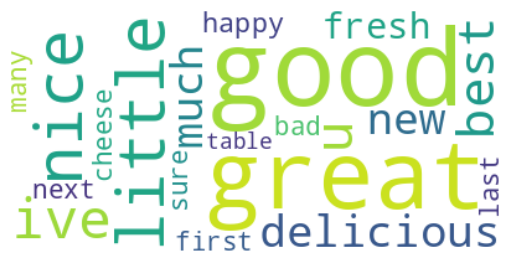

In [32]:
# Word Cloud for the frequent 20 Ajectives

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all preprocessed texts into a single string
all_text = ' '.join(df['processed_text'].tolist())

# Extract adjectives from the text
adjectives = extract_adjectives(all_text)

# Create a dictionary with the adjective counts
adjective_counts = {adjective: count for adjective, count in sorted_adjectives[:20]}

# Create the word cloud
wordcloud = WordCloud(background_color='white').generate_from_frequencies(adjective_counts)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Calculating Polarity and Subjectivity


Subjectivity and polarity scores are measures of the subjective opinions expressed in text data.

* Subjectivity score measures the degree to which the text expresses a personal opinion, feeling, or emotion rather than a factual statement. It is a float value between 0.0 and 1.0, where 0.0 indicates an objective text and 1.0 indicates a highly subjective text.

* Polarity score measures the sentiment expressed in the text, i.e., whether the text expresses a positive, negative, or neutral sentiment. It is a float value between -1.0 and 1.0, where -1.0 indicates a highly negative sentiment, 1.0 indicates a highly positive sentiment, and 0.0 indicates a neutral sentiment.

In [33]:
from textblob import TextBlob

# Define a function to calculate the polarity and subjectivity of the text
def calculate_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    return polarity, subjectivity

# Apply the function to a DataFrame column containing text
df['polarity'], df['subjectivity'] = zip(*df['text'].apply(calculate_sentiment))

df

,date,stars,text,cool,useful,funny,review length,sentiment,processed_text,polarity,subjectivity
0,2011-01-26,5,my wife took me here on my birthday for breakf...,2,5,0,868,great,wife took birthday breakfast excellent weather...,0.402469,0.659112
1,2011-07-27,5,i have no idea why some people give bad review...,0,0,0,1309,great,idea people give bad review place go show plea...,0.224091,0.638485
2,2012-06-14,4,love the gyro plate rice is so good and i also...,0,1,0,73,good,love gyro plate rice good also dig candy selec...,0.600000,0.600000
3,2010-05-27,5,rosie dakota and i love chaparral dog park its...,1,2,0,401,great,rosie dakota love chaparral dog park convenien...,0.493333,0.700000
4,2012-01-05,5,general manager scott petello is a good egg no...,0,0,0,431,great,general manager scott petello good egg go deta...,0.361111,0.788889
...,...,...,...,...,...,...,...,...,...,...,...
9995,2012-07-28,3,first visithad lunch here today used my group...,1,2,0,641,neutral,first visithad lunch today used groupon ordere...,0.217708,0.469444
9996,2012-01-18,4,should be called house of deliciousness\n\ni c...,0,0,0,867,good,called house deliciousness could go item item ...,0.375541,0.584343
9997,2010-11-16,4,i recently visited olive and ivy for business ...,0,0,0,1394,good,recently visited olive ivy business last week ...,0.256820,0.506312
9998,2012-12-02,2,my nephew just moved to scottsdale recently so...,0,0,0,816,poor,nephew moved scottsdale recently bunch friend ...,-0.071429,0.440476


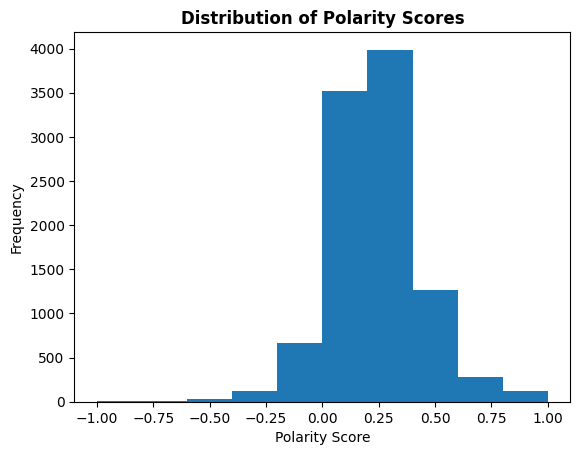

In [34]:
# Assuming 'polarity_scores' is a list/array of polarity scores
plt.hist(df['polarity'], bins=10)
plt.title('Distribution of Polarity Scores', fontweight="bold")
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.show()

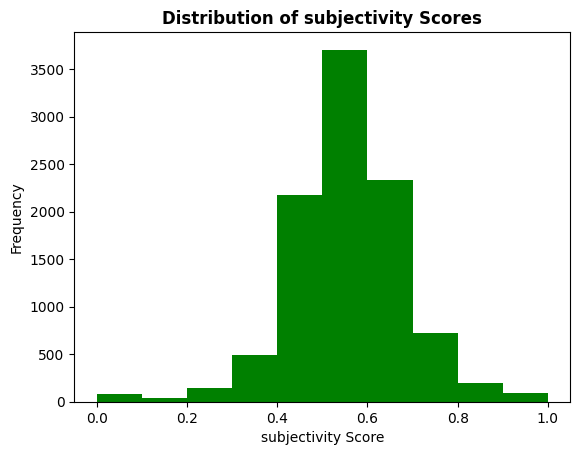

In [35]:
plt.hist(df['subjectivity'], bins=10, color = 'green')
plt.title('Distribution of subjectivity Scores',  fontweight="bold")
plt.xlabel('subjectivity Score')
plt.ylabel('Frequency')
plt.show()

In [36]:
import nltk
nltk.download('vader_lexicon')



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [37]:
df

,date,stars,text,cool,useful,funny,review length,sentiment,processed_text,polarity,subjectivity
0,2011-01-26,5,my wife took me here on my birthday for breakf...,2,5,0,868,great,wife took birthday breakfast excellent weather...,0.402469,0.659112
1,2011-07-27,5,i have no idea why some people give bad review...,0,0,0,1309,great,idea people give bad review place go show plea...,0.224091,0.638485
2,2012-06-14,4,love the gyro plate rice is so good and i also...,0,1,0,73,good,love gyro plate rice good also dig candy selec...,0.600000,0.600000
3,2010-05-27,5,rosie dakota and i love chaparral dog park its...,1,2,0,401,great,rosie dakota love chaparral dog park convenien...,0.493333,0.700000
4,2012-01-05,5,general manager scott petello is a good egg no...,0,0,0,431,great,general manager scott petello good egg go deta...,0.361111,0.788889
...,...,...,...,...,...,...,...,...,...,...,...
9995,2012-07-28,3,first visithad lunch here today used my group...,1,2,0,641,neutral,first visithad lunch today used groupon ordere...,0.217708,0.469444
9996,2012-01-18,4,should be called house of deliciousness\n\ni c...,0,0,0,867,good,called house deliciousness could go item item ...,0.375541,0.584343
9997,2010-11-16,4,i recently visited olive and ivy for business ...,0,0,0,1394,good,recently visited olive ivy business last week ...,0.256820,0.506312
9998,2012-12-02,2,my nephew just moved to scottsdale recently so...,0,0,0,816,poor,nephew moved scottsdale recently bunch friend ...,-0.071429,0.440476


# Negated Sentiment Score

The negated sentiment score can give you additional information about the sentiment of a review, specifically if the sentiment is negated or reversed. This can be useful in sentiment analysis, as negated sentiments can be important in determining the overall sentiment of a piece of text.

In [38]:
# define function to calculate negated sentiment score

from nltk.sentiment import SentimentIntensityAnalyzer

# create instance of SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
def get_negated_sentiment_score(text):
    tokens = word_tokenize(text.lower())
    negations = ["not", "no", "n't", "never", "none", "nothing", "neither", "nowhere", "hardly", "barely", "doesn't", "isn't", "wasn't", "shouldn't", "wouldn't", "couldn't", "won't", "can't"]
    negation_present = False
    score = 0
    for token in tokens:
        if token in negations:
            negation_present = True
        elif negation_present:
            score -= sia.polarity_scores(token)['compound']
            negation_present = False
        else:
            score += sia.polarity_scores(token)['compound']
    return score


# calculate sentiment scores and negated sentiment scores
df['sentiment_score'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['negated_sentiment_score'] = df['text'].apply(lambda x: get_negated_sentiment_score(x))

# filter for reviews with high negative sentiment score and high negated sentiment score
high_neg_score = df['sentiment_score'] < -0.5
high_negated_score = df['negated_sentiment_score'] > 0.5
positive_reviews = df[high_neg_score & high_negated_score]


A negated sentiment score is calculated for each review. This is important because sometimes negation words like "not" can change the meaning of a sentence. For example, "I am happy" has a positive sentiment score, but "I am not happy" has a negative sentiment score. The negated sentiment score calculates the sentiment while taking into account negation words.

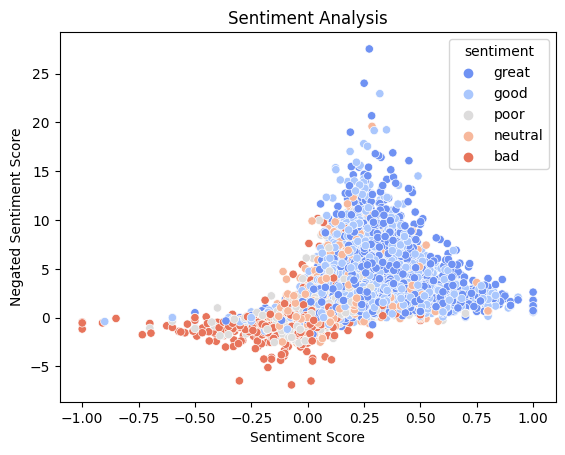

In [39]:
import seaborn as sns

# Create a scatter plot with sentiment score and negated sentiment score
sns.scatterplot(data=df, x='sentiment_score', y='negated_sentiment_score', hue='sentiment', palette='coolwarm')

# Add labels and title
plt.xlabel('Sentiment Score')
plt.ylabel('Negated Sentiment Score')
plt.title('Sentiment Analysis')

# Show the plot
plt.show()

The scatter plot with sentiment score and negated sentiment score can help you understand the relationship between the sentiment score and negated sentiment score of the reviews in your dataset.

If the majority of the points are concentrated towards the upper right quadrant, it indicates that the reviews have a high sentiment score and negated sentiment score, which could mean that they are actually positive reviews with negated words.

On the other hand, if the majority of the points are concentrated towards the lower left quadrant, it indicates that the reviews have a low sentiment score and high negated sentiment score, which could mean that they are actually negative reviews with negated words.

The scatter plot can help you identify any patterns in the data and help you make better decisions about how to analyze and interpret the sentiment of the reviews.

In [40]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create dataframes for 5-star and 1-star reviews
five_star_df = df[df['stars'] == 5]
one_star_df = df[df['stars'] == 1]

# Concatenate all the text data into a single string for each rating
five_star_text = ' '.join(five_star_df['text'].tolist())
one_star_text = ' '.join(one_star_df['text'].tolist())

# Generate word cloud for 5-star reviews
five_star_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(five_star_text)

# Generate word cloud for 1-star reviews
one_star_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(one_star_text)

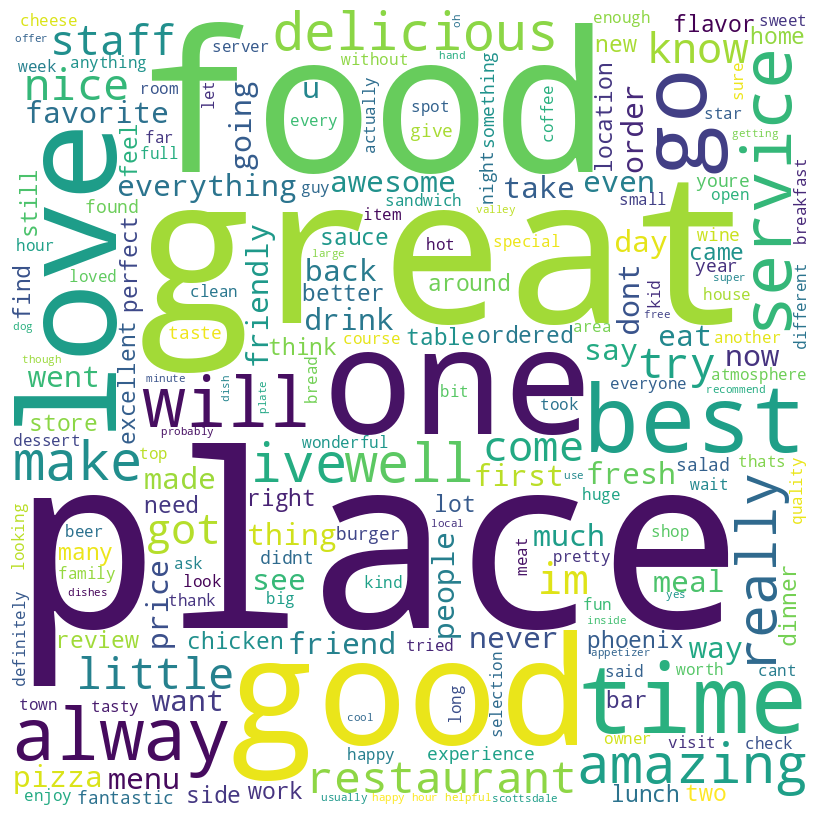

In [41]:
# Plot the word clouds for 5 star reviews
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(five_star_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

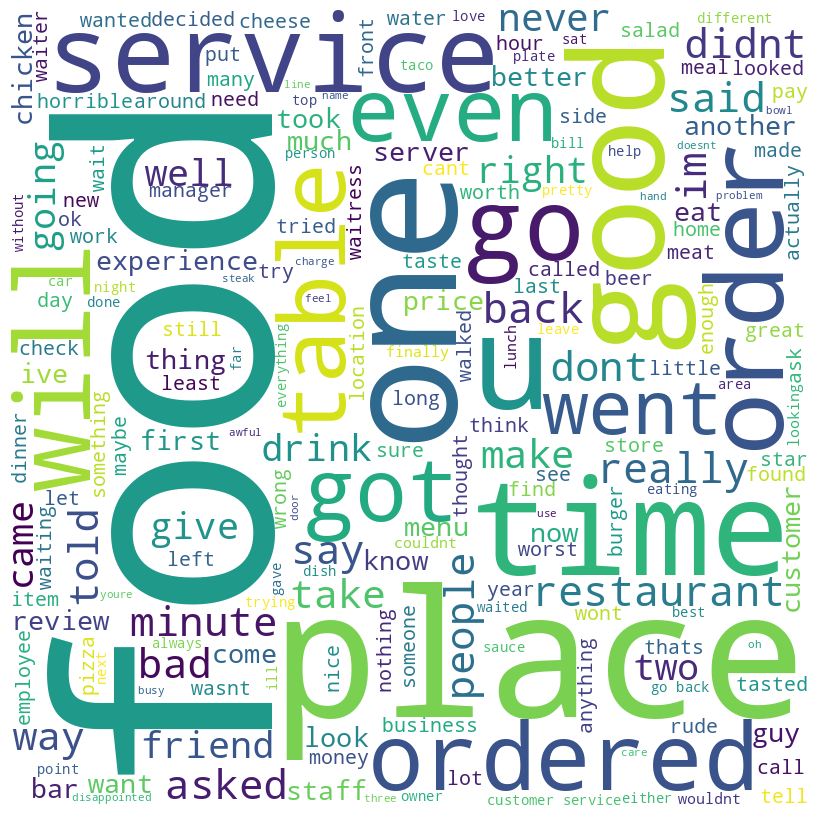

In [42]:
# Plot the word clouds for 1 star reviews

plt.figure(figsize = (8, 12), facecolor = None)
plt.imshow(one_star_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

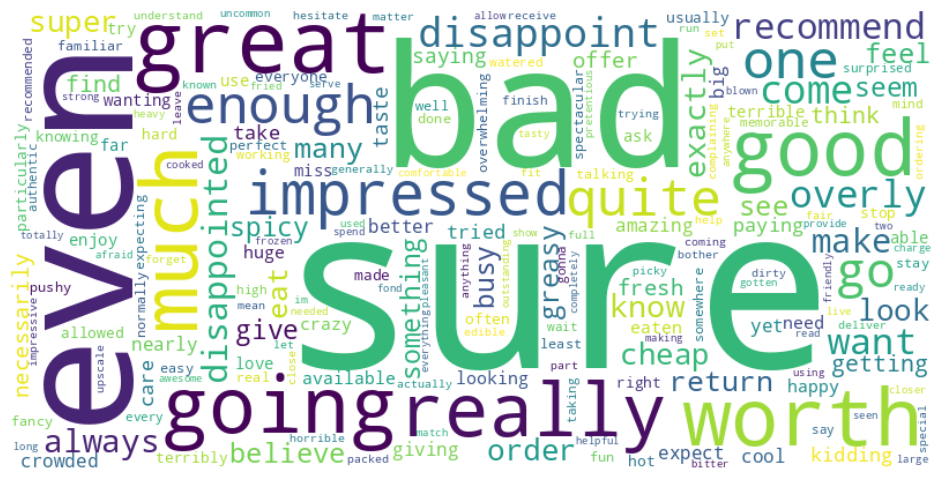

In [43]:
import re

# Define a function to extract negated words from text
def extract_negated_words(text):
    negated_words = re.findall(r'\bnot\s+[\w]+\b', text)
    return negated_words

# Extract negated words from the text column
df['negated_words'] = df['text'].apply(extract_negated_words)

# Concatenate all negated words into a single string
negated_text = ' '.join(df['negated_words'].sum())

# Generate a word cloud from the negated text
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(negated_text)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The above word cloud shows the most frequent words in negative reviews where negation words have been identified and marked. 

The word cloud gives an idea of the most commonly used negative words in reviews and how often they are used in the context of negation.






# Handling Class Imbalance

### Now, to fix the imbalance in the dataset, there are several ways:

This is done because an imbalanced dataset can bias the model towards the majority class and result in poor performance on the minority class.


#### 1. Undersampling: 
* Randomly remove some samples from the majority class to balance the dataset.

#### 2. Oversampling
* Randomly duplicate some samples from the minority class to balance the dataset.

#### 3. Synthetic Minority Over-sampling Technique (SMOTE)
* New samples are generated for the minority class using the k-nearest neighbor algorithm.


# Method 1: Undersample
Randomly remove some samples from the majority class to balance the dataset.

In [44]:
from imblearn.under_sampling import RandomUnderSampler

# Separate the features and target variable
X_r = df['processed_text']
y_r = df['sentiment']

# Apply vectorization to the features
vectorizer = CountVectorizer()
X_r = vectorizer.fit_transform(X_r)

# Apply downsampling to the majority class
rus = RandomUnderSampler(random_state=42)
X_r_resampled, y_r_resampled = rus.fit_resample(X_r, y_r)

# Check the class distribution of the resampled data
print(pd.Series(y_r_resampled).value_counts())

bad        749
good       749
great      749
neutral    749
poor       749
Name: sentiment, dtype: int64


# Multiclass classification - Undersample


Multiclass classification is a type of machine learning problem where the goal is to predict one of several possible classes. 

In this case, we want to predict the sentiment of Yelp reviews, which can be positive, negative, or neutral. To do this, we will train classification models such as Naïve Bayes, SVM, and Random Forest on the preprocessed reviews. These models will learn to recognize patterns in the data and use those patterns to make predictions about the sentiment of new reviews.

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_r_resampled, y_r_resampled, test_size=0.3, random_state=42)

# Train a random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict on the testing set and evaluate performance
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.4181494661921708
Classification Report:
              precision    recall  f1-score   support

         bad       0.53      0.65      0.59       243
        good       0.36      0.30      0.33       222
       great       0.45      0.60      0.51       215
     neutral       0.35      0.25      0.29       228
        poor       0.31      0.27      0.29       216

    accuracy                           0.42      1124
   macro avg       0.40      0.41      0.40      1124
weighted avg       0.40      0.42      0.40      1124



In [46]:
from sklearn.svm import SVC

# Train and evaluate a Support Vector Machine (SVM) model
svm = SVC(random_state=42)
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
print("Support Vector Machine (SVM) Classification Report:\n", classification_report(y_test, svm_preds))

Support Vector Machine (SVM) Classification Report:
               precision    recall  f1-score   support

         bad       0.54      0.60      0.57       243
        good       0.44      0.33      0.38       222
       great       0.48      0.67      0.56       215
     neutral       0.40      0.28      0.33       228
        poor       0.36      0.38      0.37       216

    accuracy                           0.45      1124
   macro avg       0.44      0.45      0.44      1124
weighted avg       0.45      0.45      0.44      1124



In [47]:
from sklearn.naive_bayes import MultinomialNB

# Train and evaluate a Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train, y_train)
nb_preds = nb.predict(X_test)
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_preds))

Naive Bayes Classification Report:
               precision    recall  f1-score   support

         bad       0.61      0.55      0.58       243
        good       0.40      0.41      0.41       222
       great       0.64      0.39      0.48       215
     neutral       0.33      0.36      0.34       228
        poor       0.35      0.47      0.40       216

    accuracy                           0.44      1124
   macro avg       0.46      0.44      0.44      1124
weighted avg       0.47      0.44      0.44      1124



# Method 3: Synthetic Minority Over-sampling Technique (SMOTE)

New samples are generated for the minority class using the k-nearest neighbor algorithm.


In [48]:
from imblearn.over_sampling import SMOTE

# Separate the features and target variable
X_smote = df['processed_text']
y_smote = df['sentiment']

# Apply vectorization to the features
vectorizer = CountVectorizer()
X_smote = vectorizer.fit_transform(X_smote)

# Apply SMOTE to the minority class
smote = SMOTE(random_state=42)
X_smote_resampled, y_smote_resampled = smote.fit_resample(X_smote, y_smote)

# Check the class distribution of the resampled data
print(pd.Series(y_smote_resampled).value_counts())

great      3526
good       3526
poor       3526
neutral    3526
bad        3526
Name: sentiment, dtype: int64


# Multiclass classification - SMOTE


In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smote_resampled, y_smote_resampled, test_size=0.2, random_state=42)

# Train the model
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rfc.predict(X_test)

# Evaluate the performance of the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6055019852524106
              precision    recall  f1-score   support

         bad       0.69      0.80      0.74       706
        good       0.50      0.52      0.51       766
       great       0.53      0.65      0.58       688
     neutral       0.62      0.49      0.55       673
        poor       0.73      0.57      0.64       693

    accuracy                           0.61      3526
   macro avg       0.61      0.61      0.60      3526
weighted avg       0.61      0.61      0.60      3526



In [54]:
# SVM - Smote
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smote_resampled, y_smote_resampled, test_size=0.3, random_state=42)

# Fit the SVM model on the training data
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

# Evaluate the performance of the model on the testing data
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bad       0.60      0.83      0.69      1049
        good       0.48      0.49      0.49      1126
       great       0.55      0.53      0.54      1040
     neutral       0.54      0.48      0.50      1038
        poor       0.68      0.49      0.57      1036

    accuracy                           0.56      5289
   macro avg       0.57      0.56      0.56      5289
weighted avg       0.57      0.56      0.56      5289



In [55]:
#NB - Smote

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smote_resampled, y_smote_resampled, test_size=0.3, random_state=42)

# Fit the Naive Bayes model on the training data
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Evaluate the performance of the model on the testing data
y_pred = nb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bad       0.79      0.48      0.59      1049
        good       0.44      0.65      0.53      1126
       great       0.53      0.58      0.55      1040
     neutral       0.52      0.41      0.46      1038
        poor       0.51      0.51      0.51      1036

    accuracy                           0.53      5289
   macro avg       0.56      0.53      0.53      5289
weighted avg       0.56      0.53      0.53      5289

